In [1]:
import sagemaker

session = sagemaker.Session()
bucket = session.default_bucket()

print(bucket)

sagemaker-us-east-1-011113936377


In [2]:
!aws s3 sync s3://{bucket}/wsb/data/ data/

In [3]:
import sys
import re
import os
import json
import datetime
import pytz
import numpy as np


In [4]:
ET = pytz.timezone('US/Eastern')

ignorelist=["DD","FREE","CASH","ON","I"]
allsymbols=[]
with open("allsymbols.txt") as fh:
    allsymbols=fh.readlines()
allsymbols = [x.strip() for x in allsymbols]

dt=datetime.timedelta(days=7)


In [5]:
import time, sys
from IPython.display import clear_output

def update_progress(progress):
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1

    block = int(round(bar_length * progress))

    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)

In [6]:
import datetime

stockdata={}
def getstockprice(symbol,date):
    if symbol not in stockdata:
        with open("stockprices/"+symbol,"r") as fh:
            data=json.load(fh)
        stockdata[symbol]={}
        for stockday in data:
            indate=datetime.datetime.strptime(stockday["begins_at"],"%Y-%m-%dT%H:%M:%SZ").date()
            stockdata[symbol][indate]=stockday
    today=datetime.date.today()
    while True:
        #print(date)
        if date in stockdata[symbol]:
            return float(stockdata[symbol][date]['close_price'])
        date=date+datetime.timedelta(days=1)
        if date>today:
            break
    raise Exception("No stock data found")
    return None
            

In [7]:
files = os.listdir("data/")

foundsymbols=[]
relevant_posts = []
i=0
for file in files:
  if(round(i/100,0)==i/100):
        update_progress(i / len(files))  
  with open("data/"+file,"r") as fh:
    try:
        data=json.load(fh)
        text = (data["title"]+" "+data["selftext"]).replace('\"','').replace('\'','')
        allmatches=[]
        matches=re.findall('\W*([A-Z][A-Z\.]{0,3})\W',text)
        for submatch in matches:
            allmatches.append({submatch:submatch})
            #pass
        matches2=re.findall('\W*(\$[a-z\.]{1,4})',text)
        for submatch in matches2:
            allmatches.append({submatch.upper()[1:]:submatch})
        thesesymbols=[]
        #print(allmatches)
        for submatch in allmatches:
            symbol=list(submatch.keys())[0]
            #print(submatch.keys())
            #print(symbol)
            #print([list(x.keys())[0] for x in thesesymbols])
            if symbol in allsymbols and symbol not in [list(x.keys())[0] for x in thesesymbols] and symbol not in ignorelist:
                thesesymbols.append(submatch)
                if symbol not in foundsymbols:
                    foundsymbols.append(symbol)
        if len(thesesymbols)>0:
            relevant_posts.append({"data":data,"symbols":thesesymbols})
            #print(thesesymbols)
    except Exception as err:
      print("Error with",file)
      raise(err)
  i+=1
    

  #if i>1000:
  #  break



Progress: [####################] 99.9%


In [8]:
print(len(foundsymbols))
with open("foundsymbols.txt","w") as fh:
    fh.write("\n".join(foundsymbols))
foundsymbols

3661


['TSLA',
 'B',
 'AMZN',
 'COST',
 'C',
 'LULU',
 'AMD',
 'FB',
 'PTON',
 'AAPL',
 'GOLD',
 'ROKU',
 'NFLX',
 'DIS',
 'HAS',
 'GOOD',
 'ONCY',
 'SPCE',
 'AMC',
 'KR',
 'PM',
 'ABC',
 'X',
 'Y',
 'CYBR',
 'PANW',
 'RPD',
 'EDIT',
 'DTE',
 'DCOM',
 'AT',
 'ACB',
 'THC',
 'MU',
 'IP',
 'AG',
 'GILD',
 'TJX',
 'HTZ',
 'TVTY',
 'DGX',
 'QQQ',
 'TA',
 'BYND',
 'POST',
 'SR',
 'NIO',
 'RING',
 'A',
 'NEW',
 'IT',
 'FOSL',
 'BK',
 'PINS',
 'KRTX',
 'OVID',
 'DOW',
 'SBUX',
 'VC',
 'MCD',
 'MSFT',
 'WMT',
 'SNAP',
 'PECK',
 'HUGE',
 'GDP',
 'WELL',
 'CDC',
 'BA',
 'V',
 'FAT',
 'NOC',
 'LMT',
 'RH',
 'AAL',
 'GO',
 'SDC',
 'ALGN',
 'ONE',
 'ATVI',
 'M',
 'CEO',
 'K',
 'ALLY',
 'SIX',
 'CME',
 'AM',
 'LIVE',
 'FIT',
 'SWBI',
 'EC',
 'F',
 'CRM',
 'BAC',
 'CTO',
 'PEP',
 'UAL',
 'DAL',
 'JNJ',
 'PCG',
 'E',
 'PLUS',
 'AMTD',
 'TTD',
 'DEA',
 'CBD',
 'CCL',
 'ARE',
 'OUT',
 'G',
 'BMO',
 'IONS',
 'FOR',
 'HAL',
 'INFY',
 'KO',
 'SYF',
 'NDAQ',
 'NEE',
 'ERIC',
 'DPZ',
 'LUV',
 'UNP',
 'AXP',
 'SNY'

In [9]:
#split into multiple corpus here


import random
random.shuffle(relevant_posts)
n_train = int(0.8 * len(relevant_posts))

training_posts = relevant_posts[:n_train]
test_posts = relevant_posts[n_train:]
val_posts = test_posts[:n_train//2]
test_posts = test_posts[n_train//2:]

vocab_input = [t["data"]["title"]+" "+t["data"]["selftext"] for t in training_posts]
print(len(relevant_posts),n_train)

34504 27603


In [10]:
test_posts = relevant_posts[n_train:]
print(n_train,n_train//2)
test_posts = relevant_posts[n_train:]
print(len(test_posts))
print(len(test_posts)//2)
val_posts = test_posts[:len(test_posts)//2]
test_posts = test_posts[len(test_posts)//2:]
len(test_posts)

27603 13801
6901
3450


3451

In [11]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [12]:
training_data=""
for post in training_posts:
    data=post["data"]
    thesesymbols=post["symbols"]
    text = data["title"]+" "+data["selftext"] 
    training_data += text.replace("\n","")+"\n"

In [13]:
%%time

import boto3
prefix='wsb-xgboost-blazingtextinput'
region = boto3.Session().region_name
s3=boto3.client('s3')

train_channel = prefix + '/train'

s3.put_object(Bucket=bucket,Key=train_channel,Body=training_data)

s3_train_data = 's3://{}/{}'.format(bucket, train_channel)


CPU times: user 167 ms, sys: 31.3 ms, total: 199 ms
Wall time: 425 ms


In [14]:
s3_output_location = 's3://{}/{}/output'.format(bucket, prefix)

In [15]:
train_data_input = sagemaker.session.s3_input(s3_train_data, distribution='FullyReplicated', 
                        content_type='text/plain', s3_data_type='S3Prefix')
data_channels = {'train': train_data_input}

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


In [16]:
region_name = boto3.Session().region_name
container = sagemaker.amazon.amazon_estimator.get_image_uri(region_name, "blazingtext", "latest")
print('Using SageMaker BlazingText container: {} ({})'.format(container, region_name))


'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


Using SageMaker BlazingText container: 811284229777.dkr.ecr.us-east-1.amazonaws.com/blazingtext:latest (us-east-1)


In [17]:
role = sagemaker.get_execution_role()

bt_model = sagemaker.estimator.Estimator(container,
                                         role, 
                                         train_instance_count=1, 
                                         train_instance_type='ml.m4.10xlarge',
                                         train_volume_size = 30,
                                         train_max_run = 360000,
                                         input_mode= 'File',
                                         output_path=s3_output_location,
                                         sagemaker_session=session)

Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


In [18]:


bt_model.set_hyperparameters(mode="batch_skipgram")


In [19]:
train_data_input = sagemaker.session.s3_input(s3_train_data, distribution='FullyReplicated', 
                        content_type='text/plain', s3_data_type='S3Prefix')

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


In [20]:
%%time

bt_model.fit(inputs=data_channels, logs=True)

2020-08-12 11:36:37 Starting - Starting the training job...
2020-08-12 11:36:39 Starting - Launching requested ML instances.........
2020-08-12 11:38:21 Starting - Preparing the instances for training...
2020-08-12 11:39:07 Downloading - Downloading input data...
2020-08-12 11:39:35 Training - Training image download completed. Training in progress..Arguments: train
[08/12/2020 11:39:36 WARNING 140694822393664] Loggers have already been setup.
[08/12/2020 11:39:36 WARNING 140694822393664] Loggers have already been setup.
[08/12/2020 11:39:36 INFO 140694822393664] nvidia-smi took: 0.0252499580383 secs to identify 0 gpus
[08/12/2020 11:39:36 INFO 140694822393664] Running single machine CPU BlazingText training using batch_skipgram mode.
[08/12/2020 11:39:36 INFO 140694822393664] Processing /opt/ml/input/data/train/train . File size: 20 MB
Read 3M words
Number of words:  33418
##### Alpha: 0.0489  Progress: 2.16%  Million Words/sec: 0.21 #####
##### Alpha: 0.0440  Progress: 11.94%  Millio

In [21]:
text_vectorizer = bt_model.deploy(initial_instance_count = 1,instance_type = 'ml.m4.xlarge')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


---------------!

In [22]:
threshhold=.05

def calculateData(post):
    #print(post)
    data=post["data"]
    thesesymbols=post["symbols"]
    text = (data["title"]+" "+data["selftext"]).lower().strip()
    payload = {"instances" : text.split(" ")}
    response = text_vectorizer.predict(json.dumps(payload))
    wordvectors=json.loads(response)
    finalvector=[]
    i=0
    while i<len(wordvectors[0]["vector"]):
        sum=0
        for vector in wordvectors:
            sum+=vector["vector"][i]
        finalvector.append(sum/len(wordvectors))
        i+=1
    returnarray=[]
    for symbolmap in thesesymbols:
        symbol=list(symbolmap.keys())[0]
        try:
            posttime=[0,0,0,0]
            start=ET.localize(datetime.datetime.fromtimestamp(data["created_utc"]))
            if start.hour>=21:
                posttime[0]=1
            elif start.hour < 5:
                posttime[0]=1
            elif start.hour < 9:
                posttime[1]=1
            elif start.hour < 16:
                posttime[2]=1
            else:
                posttime[3]=1
            if start.hour>=9:
                start=start+datetime.timedelta(days=1)
            start=start.replace(hour=9,minute=0,second=0,microsecond=0).date()
            end=start+dt
            startprice=getstockprice(symbol,start)
            endprice=getstockprice(symbol,end)
            #print(start,end,history)
            delta=(endprice-startprice)/startprice
            if delta<=-1*(threshhold):
                result=1
            elif delta>=threshhold:
                result=2
                #print(symbol,delta,result,wordvector)
            else:
                result=0
            returnarray.append([result]+posttime+finalvector)
        except Exception as err:
            print("Error with",symbol,", skipping this one:",err)
    return returnarray


def calculateVectors(posts):
    vector = []
    i=0
    for post in posts:
        #try:
        if True:
           response=calculateData(post)
           for row in response:
                vector.append(row)
        #except Exception as err:
        #    print("Error",err)
        #    pass
        i+=1
        if(round(i/100,0)==i/100):
            update_progress(i / len(posts))
    vector=np.array(vector).astype('float32')
    return vector

training_vector = calculateVectors(training_posts)
test_vector = calculateVectors(test_posts)
val_vector = calculateVectors(val_posts)

Progress: [####################] 98.6%


In [23]:
import pandas as pd
pd.DataFrame(training_vector)
#, columns=["Output"]+["21-4","5-8","9-15","16-20"]+vocab_list)

,0,1,2,3,4,5,6,7,8,9,...,95,96,97,98,99,100,101,102,103,104
0,1.0,0.0,1.0,0.0,0.0,0.095804,-0.087814,0.025540,-0.053197,0.126771,...,-0.037107,-0.057648,-0.058793,-0.003006,-0.113399,-0.187654,0.114351,-0.118884,-0.089884,0.079843
1,2.0,0.0,0.0,0.0,1.0,0.033358,-0.146760,0.036176,-0.080971,0.234291,...,0.010940,-0.054865,-0.005561,-0.014394,-0.080697,-0.121462,0.085644,-0.024949,0.006310,0.037648
2,0.0,1.0,0.0,0.0,0.0,-0.013029,-0.068696,0.103349,-0.070707,0.170746,...,0.020514,-0.093141,-0.033443,-0.080464,-0.109709,-0.103708,0.102948,-0.085778,-0.025263,0.081768
3,2.0,0.0,1.0,0.0,0.0,-0.049690,-0.066934,0.042591,-0.121681,0.188072,...,0.028509,-0.061218,-0.036691,-0.024849,-0.119983,-0.200041,0.106047,-0.062466,-0.006391,-0.009454
4,1.0,1.0,0.0,0.0,0.0,-0.000967,-0.042833,-0.059715,-0.007330,0.158289,...,0.013522,-0.059336,-0.084651,0.092301,0.050566,-0.117293,0.199127,0.034720,0.092678,-0.067078
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68160,1.0,0.0,0.0,0.0,1.0,-0.015993,-0.076515,0.109973,-0.110123,0.121322,...,-0.013332,-0.098388,-0.048379,-0.014682,-0.119611,-0.205840,0.104697,-0.081638,-0.054823,-0.010432
68161,0.0,0.0,0.0,0.0,1.0,-0.015993,-0.076515,0.109973,-0.110123,0.121322,...,-0.013332,-0.098388,-0.048379,-0.014682,-0.119611,-0.205840,0.104697,-0.081638,-0.054823,-0.010432
68162,0.0,0.0,0.0,0.0,1.0,-0.166538,-0.013575,0.103940,-0.134188,0.258998,...,-0.037514,-0.158748,-0.088862,-0.032858,-0.079548,-0.145821,0.093666,0.108516,-0.061342,0.080608
68163,0.0,1.0,0.0,0.0,0.0,0.003795,-0.057567,0.108574,-0.073038,0.163025,...,0.023940,-0.043838,-0.022420,-0.096765,-0.109281,-0.134169,0.052367,-0.080316,-0.094668,0.053554


In [24]:
training_vector[0:1]

array([[ 1.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  9.58035290e-02,
        -8.78143087e-02,  2.55396944e-02, -5.31969927e-02,
         1.26770526e-01, -3.37156318e-02, -7.88293779e-02,
        -1.09234825e-01,  1.29876867e-01, -1.01910390e-01,
         8.33610967e-02, -4.92631458e-02, -1.71867698e-01,
         2.70649880e-01, -4.49103229e-02, -7.32179582e-02,
         4.64837588e-02, -1.68277130e-01, -9.00842994e-02,
        -1.77753950e-03,  1.53329432e-01,  3.11993491e-02,
         1.09183840e-01, -8.97244886e-02, -1.94418877e-01,
        -5.91193140e-02,  8.69750157e-02, -2.68545616e-02,
        -1.45415105e-02, -1.10727258e-01, -6.61747307e-02,
        -9.83782038e-02,  2.87093092e-02,  8.94612372e-02,
        -2.23170575e-02,  3.10077034e-02, -6.94740787e-02,
        -7.93923214e-02,  9.69330817e-02,  1.61342338e-01,
        -1.44243196e-01, -7.41185322e-02,  3.44015099e-02,
         4.65606339e-02,  2.57929564e-02,  1.16434038e-0

In [25]:
%%time

import struct
import io
import boto3

prefix='wsb-xgboost-blazingtextinput-xgboostrun'
region = boto3.Session().region_name
 
def to_libsvm(f, labels, values):
     f.write(bytes('\n'.join(
         ['{} {}'.format(label, ' '.join(['{}:{}'.format(i + 1, el) for i, el in enumerate(vec)])) for label, vec in
          zip(labels, values)]), 'utf-8'))
     return f


def write_to_s3(fobj, bucket, key):
    return boto3.Session(region_name=region).resource('s3').Bucket(bucket).Object(key).upload_fileobj(fobj)

def upload_to_s3(partition_name, partition):
    labels = [t.tolist() for t in partition[:,0]]
    vectors = [t.tolist() for t in partition[:,1:]]
    num_partition = 5                                 # partition file into 5 parts
    partition_bound = int(len(labels)/num_partition)
    for i in range(num_partition):
        f = io.BytesIO()
        to_libsvm(f, labels[i*partition_bound:(i+1)*partition_bound], vectors[i*partition_bound:(i+1)*partition_bound])
        f.seek(0)
        key = "{}/{}/examples{}".format(prefix,partition_name,str(i))
        url = 's3n://{}/{}'.format(bucket, key)
        print('Writing to {}'.format(url))
        write_to_s3(f, bucket, key)
        print('Done writing to {}'.format(url))

def download_from_s3(partition_name, number, filename):
    key = "{}/{}/examples{}".format(prefix,partition_name, number)
    url = 's3n://{}/{}'.format(bucket, key)
    print('Reading from {}'.format(url))
    s3 = boto3.resource('s3', region_name = region)
    s3.Bucket(bucket).download_file(key, filename)
    #try:
    #    s3.Bucket(bucket).download_file(key, 'mnist.local.test')
    #except botocore.exceptions.ClientError as e:
    #    if e.response['Error']['Code'] == "404":
    #        print('The object does not exist at {}.'.format(url))
    #    else:
    #        raise        
        
def convert_data():
    partitions = [('train', training_vector), ('validation', val_vector), ('test', test_vector)]
    for partition_name, partition in partitions:
        print('{}: {} {}'.format(partition_name, partition[:,0].shape, partition[:,1:].shape))
        upload_to_s3(partition_name, partition)

CPU times: user 9.52 ms, sys: 99 µs, total: 9.62 ms
Wall time: 9.46 ms


In [26]:
val_vector[:,1:].shape

(8819, 104)

In [27]:
%%time

convert_data()

train: (68165,) (68165, 104)
Writing to s3n://sagemaker-us-east-1-011113936377/wsb-xgboost-blazingtextinput-xgboostrun/train/examples0
Done writing to s3n://sagemaker-us-east-1-011113936377/wsb-xgboost-blazingtextinput-xgboostrun/train/examples0
Writing to s3n://sagemaker-us-east-1-011113936377/wsb-xgboost-blazingtextinput-xgboostrun/train/examples1
Done writing to s3n://sagemaker-us-east-1-011113936377/wsb-xgboost-blazingtextinput-xgboostrun/train/examples1
Writing to s3n://sagemaker-us-east-1-011113936377/wsb-xgboost-blazingtextinput-xgboostrun/train/examples2
Done writing to s3n://sagemaker-us-east-1-011113936377/wsb-xgboost-blazingtextinput-xgboostrun/train/examples2
Writing to s3n://sagemaker-us-east-1-011113936377/wsb-xgboost-blazingtextinput-xgboostrun/train/examples3
Done writing to s3n://sagemaker-us-east-1-011113936377/wsb-xgboost-blazingtextinput-xgboostrun/train/examples3
Writing to s3n://sagemaker-us-east-1-011113936377/wsb-xgboost-blazingtextinput-xgboostrun/train/example

In [28]:
from sagemaker.amazon.amazon_estimator import get_image_uri
container = get_image_uri(region, 'xgboost')

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
There is a more up to date SageMaker XGBoost image. To use the newer image, please set 'repo_version'='1.0-1'. For example:
	get_image_uri(region, 'xgboost', '1.0-1').


In [29]:
tuning_job_config = {
    "ParameterRanges": {
      "CategoricalParameterRanges": [],
      "ContinuousParameterRanges": [
        {
          "MaxValue": "1",
          "MinValue": "0",
          "Name": "eta"
        },
        {
          "MaxValue": "2",
          "MinValue": "0",
          "Name": "alpha"
        },
        {
          "MaxValue": "10",
          "MinValue": "1",
          "Name": "min_child_weight"
        }
      ],
      "IntegerParameterRanges": [
        {
          "MaxValue": "10",
          "MinValue": "1",
          "Name": "max_depth"
        }
      ]
    },
    "ResourceLimits": {
      "MaxNumberOfTrainingJobs": 20,
      "MaxParallelTrainingJobs": 3
    },
    "Strategy": "Bayesian",
    "HyperParameterTuningJobObjective": {
      "MetricName": "validation:merror",
      "Type": "Minimize"
    }
  }

In [30]:
from sagemaker import get_execution_role

role = get_execution_role()
bucket_path = 'https://s3-{}.amazonaws.com/{}'.format(region,bucket)

In [31]:
training_job_definition = {
    "AlgorithmSpecification": {
      "TrainingImage": container,
      "TrainingInputMode": "File"
    },
    "InputDataConfig": [
        {
            "ChannelName": "train",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": bucket_path + "/"+ prefix+ '/train/',
                    "S3DataDistributionType": "FullyReplicated" 
                }
            },
            "ContentType": "libsvm",
            "CompressionType": "None"
        },
        {
            "ChannelName": "validation",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": bucket_path + "/"+ prefix+ '/validation/',
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
            "ContentType": "libsvm",
            "CompressionType": "None"
        }
    ],
    "OutputDataConfig": {
      "S3OutputPath": "s3://{}/{}/xgboost".format(bucket,prefix)
    },
    "ResourceConfig": {
        "InstanceCount": 2,   
        "InstanceType": "ml.m4.10xlarge",
        "VolumeSizeInGB": 5
    },
    "RoleArn": role,
    "StaticHyperParameters": {
      "eval_metric": "merror",
      "num_round": "100",
      "objective": "multi:softmax",
      "num_class": "3",
      "rate_drop": "0.3",
      "tweedie_variance_power": "1.4"
    },
    "StoppingCondition": {
      "MaxRuntimeInSeconds": 43200
    }
}

In [32]:
from time import gmtime, strftime

sm = boto3.Session(region_name=region).client('sagemaker')

tuning_job_name = "MyTuningJob" + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
sm.create_hyper_parameter_tuning_job(HyperParameterTuningJobName = tuning_job_name,
                                           HyperParameterTuningJobConfig = tuning_job_config,
                                           TrainingJobDefinition = training_job_definition)

{'HyperParameterTuningJobArn': 'arn:aws:sagemaker:us-east-1:011113936377:hyper-parameter-tuning-job/mytuningjob2020-08-12-12-07-42',
 'ResponseMetadata': {'RequestId': 'dddcb737-d08c-43a0-944c-8c7b84bc8d5e',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'dddcb737-d08c-43a0-944c-8c7b84bc8d5e',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '131',
   'date': 'Wed, 12 Aug 2020 12:07:42 GMT'},
  'RetryAttempts': 0}}

In [33]:
%%time



#sm.create_training_job(**single_machine_job_params)

status = sm.describe_hyper_parameter_tuning_job(HyperParameterTuningJobName=tuning_job_name)['HyperParameterTuningJobStatus']
while status in ["InProgress","Stopping"]:
  print(status)
  time.sleep(60)
  status = sm.describe_hyper_parameter_tuning_job(HyperParameterTuningJobName=tuning_job_name)['HyperParameterTuningJobStatus']

print("Tuning job ended with status: " + status)
if status == 'Failed':
    message = sm.describe_hyperparameter_tuning_job(HyperParameterTuningJobName=tuning_job_name)['FailureReason']
    print('Tuning job failed with the following error: {}'.format(message))
    raise Exception('Training job failed')

InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
Tuning job ended with status: Completed
CPU times: user 636 ms, sys: 71.5 ms, total: 708 ms
Wall time: 47min 5s


In [34]:
%%time
import boto3
from time import gmtime, strftime

model_name= 'XGBoostModel-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print(model_name)

training_job_name=sm.describe_hyper_parameter_tuning_job(HyperParameterTuningJobName=tuning_job_name)["BestTrainingJob"]["TrainingJobName"]

info = sm.describe_training_job(TrainingJobName=training_job_name)
model_data = info['ModelArtifacts']['S3ModelArtifacts']
print(model_data)

primary_container = {
    'Image': container,
    'ModelDataUrl': model_data
}

create_model_response = sm.create_model(
    ModelName = model_name,
    ExecutionRoleArn = role,
    PrimaryContainer = primary_container)

print(create_model_response['ModelArn'])

XGBoostModel-2020-08-12-12-54-48
s3://sagemaker-us-east-1-011113936377/wsb-xgboost-blazingtextinput-xgboostrun/xgboost/MyTuningJob2020-08-12-12-07-42-012-da4c3584/output/model.tar.gz
arn:aws:sagemaker:us-east-1:011113936377:model/xgboostmodel-2020-08-12-12-54-48
CPU times: user 12.6 ms, sys: 0 ns, total: 12.6 ms
Wall time: 517 ms


In [35]:
from time import gmtime, strftime

endpoint_config_name = 'DEMO-XGBoostEndpointConfig-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print(endpoint_config_name)
create_endpoint_config_response = sm.create_endpoint_config(
    EndpointConfigName = endpoint_config_name,
    ProductionVariants=[{
        'InstanceType':'ml.m4.xlarge',
        'InitialVariantWeight':1,
        'InitialInstanceCount':1,
        'ModelName':model_name,
        'VariantName':'AllTraffic'}])

print("Endpoint Config Arn: " + create_endpoint_config_response['EndpointConfigArn'])

DEMO-XGBoostEndpointConfig-2020-08-12-12-54-48
Endpoint Config Arn: arn:aws:sagemaker:us-east-1:011113936377:endpoint-config/demo-xgboostendpointconfig-2020-08-12-12-54-48


In [36]:
%%time
import time

endpoint_name = 'DEMO-XGBoostEndpoint-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print(endpoint_name)
create_endpoint_response = sm.create_endpoint(
    EndpointName=endpoint_name,
    EndpointConfigName=endpoint_config_name)
print(create_endpoint_response['EndpointArn'])

resp = sm.describe_endpoint(EndpointName=endpoint_name)
status = resp['EndpointStatus']
print("Status: " + status)

while status=='Creating':
    time.sleep(60)
    resp = sm.describe_endpoint(EndpointName=endpoint_name)
    status = resp['EndpointStatus']
    print("Status: " + status)

print("Arn: " + resp['EndpointArn'])
print("Status: " + status)

DEMO-XGBoostEndpoint-2020-08-12-12-54-49
arn:aws:sagemaker:us-east-1:011113936377:endpoint/demo-xgboostendpoint-2020-08-12-12-54-49
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: InService
Arn: arn:aws:sagemaker:us-east-1:011113936377:endpoint/demo-xgboostendpoint-2020-08-12-12-54-49
Status: InService
CPU times: user 120 ms, sys: 4.32 ms, total: 124 ms
Wall time: 8min


In [37]:
runtime_client = boto3.client('runtime.sagemaker', region_name=region)

In [38]:
download_from_s3('test', 0, 'wsb.local.test') # reading the first part file within test

Reading from s3n://sagemaker-us-east-1-011113936377/wsb-xgboost-blazingtextinput-xgboostrun/test/examples0


In [39]:
!head -1 wsb.local.test > wsb.single.test

In [40]:
%%time
import json

file_name = 'wsb.single.test' #customize to your test file 'mnist.single.test' if use the data above

with open(file_name, 'r') as f:
    payload = f.read()

response = runtime_client.invoke_endpoint(EndpointName=endpoint_name, 
                                   ContentType='text/x-libsvm', 
                                   Body=payload)
result = response['Body'].read().decode('ascii')
print('Predicted label is {}.'.format(result))

Predicted label is 0.0.
CPU times: user 9.9 ms, sys: 4.13 ms, total: 14 ms
Wall time: 293 ms


In [41]:
import sys
def do_predict(data, endpoint_name, content_type):
    payload = '\n'.join(data)
    response = runtime_client.invoke_endpoint(EndpointName=endpoint_name, 
                                   ContentType=content_type, 
                                   Body=payload)
    result = response['Body'].read().decode('ascii')
    preds = [float(num) for num in result.split(',')]
    return preds

def batch_predict(data, batch_size, endpoint_name, content_type):
    items = len(data)
    arrs = []
    for offset in range(0, items, batch_size):
        arrs.extend(do_predict(data[offset:min(offset+batch_size, items)], endpoint_name, content_type))
        sys.stdout.write('.')
    return(arrs)

In [42]:
%%time
import json

file_name = 'wsb.local.test'
with open(file_name, 'r') as f:
    payload = f.read().strip()
labels = [float(line.split(' ')[0]) for line in payload.split('\n')]
test_data = payload.split('\n')
preds = batch_predict(test_data, 100, endpoint_name, 'text/x-libsvm')

print ('\nerror rate=%f' % ( sum(1 for i in range(len(preds)) if preds[i]!=labels[i]) /float(len(preds))))

...................
error rate=0.466408
CPU times: user 105 ms, sys: 3.35 ms, total: 108 ms
Wall time: 1.33 s


In [43]:
preds[0:10]

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [44]:
labels[0:10]

[1.0, 2.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0]

In [45]:
import numpy
def error_rate(predictions, labels):
    """Return the error rate and confusions."""
    correct = numpy.sum(predictions == labels)
    total = predictions.shape[0]

    error = 100.0 - (100 * float(correct) / float(total))

    confusions = numpy.zeros([3,3], numpy.int32)
    bundled = zip(predictions, labels)
    for predicted, actual in bundled:
        confusions[int(predicted), int(actual)] += 1
    
    return error, confusions

Test error: 46.6%


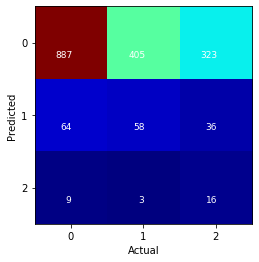

In [46]:
import matplotlib.pyplot as plt
%matplotlib inline  

NUM_LABELS = 3  # change it according to num_class in your dataset
test_error, confusions = error_rate(numpy.asarray(preds), numpy.asarray(labels))
print('Test error: %.1f%%' % test_error)

plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.grid(False)
plt.xticks(numpy.arange(NUM_LABELS))
plt.yticks(numpy.arange(NUM_LABELS))
plt.imshow(confusions, cmap=plt.cm.jet, interpolation='nearest');

for i, cas in enumerate(confusions):
    for j, count in enumerate(cas):
        if count > 0:
            xoff = .07 * len(str(count))
            plt.text(j-xoff, i+.2, int(count), fontsize=9, color='white')

In [47]:
sm.delete_endpoint(EndpointName=endpoint_name)
session.delete_endpoint(text_vectorizer.endpoint)

In [48]:
import sklearn
print(sklearn.metrics.classification_report(numpy.asarray(labels),numpy.asarray(preds)))

              precision    recall  f1-score   support

         0.0       0.55      0.92      0.69       960
         1.0       0.37      0.12      0.19       466
         2.0       0.57      0.04      0.08       375

    accuracy                           0.53      1801
   macro avg       0.50      0.36      0.32      1801
weighted avg       0.51      0.53      0.43      1801



In [49]:
filter_arr = numpy.asarray(preds) == numpy.asarray(labels)
newarr = numpy.asarray(preds)[filter_arr]
bearbear = np.count_nonzero(newarr == 1)
bullbull = np.count_nonzero(newarr == 2)
bullbear=numpy.count_nonzero((numpy.asarray(preds) == 2) & (numpy.asarray(labels) == 1))
bearbull=numpy.count_nonzero((numpy.asarray(preds) == 1) & (numpy.asarray(labels) == 2))
print("Bull Rating:",bullbull/(bullbull+bullbear))
print("Bear Rating:",bearbear/(bearbear+bearbull))


Bull Rating: 0.8421052631578947
Bear Rating: 0.6170212765957447
